# PINN analysis for Black-Scholes model

### Idea:
We will use a Physics Informed Neural Network to find the solution for BLack and Scholes differential equation with boundary conditions of Call options. One of advantages for this appriach is that, contrary to the original BS model, one can find solutions even when volatility is time dependent. The second advantage is application of "Inverse Parameter Finding" problem of PINN to find implied volatility. <br>
This second advantage is actually what is used in this notebook. To be precise, we give noisy boundary condition to PINN, where the noise is imported from the GARCH analysis of the timeseries.<br>
Finally, since the solution of the BS equaiton (i.e. option price) is the output of a neural network defined under tensorflow, one can use the automatic differentiation techniqiues to find derivatives of the solutions relative to paramters. To this end, in addtion to the independent variables of the PDE, we add an input node to the neural network for each parameter we want to take derivative with. But since we want to also find the best fitted parameter (in this case volatility) the numeric value given to these extra nodes are constant (1.), but the activiation function acting on these node depends linearly to these learnable parameter. In this way one can both train these paramters and also take derivative relative them.<br>
At the end we will download the trained neural net (for maurity time 20) in a "weight.h5" and deployed in streamlit. <br>

In principle one can use the package DeepXDE designed for finding PINN solutions. But since one needs to take derivative relative to the solutions, define custom activation functions, and saving the weights, we found it simpler to use the version of a PINN model written from scratch and handed to students in PINN course of U-Alberta (prof. V. Putkaradze).

## First Principle PINN:

In [285]:
from time import time  # to use timers

import numpy as np  # for creating and manipulating numeric arrays with data
import tensorflow as tf  # Tensorflow as a backend for neural networks
import keras  # Keras as separate package (important!), for layers and convinient API
from keras.layers import Dense, Lambda  # neural network layers
import scipy # version 1.15.1
from scipy.integrate import solve_ivp  # ODE solver
from scipy.stats import norm
from functools import partial
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt  # for plotting figures with results
from matplotlib import colormaps as cm

import os  # for environment utlities, such env variables
os.environ["KERAS_BACKEND"] = "tensorflow"  # Keras to use Tensorflow as backend
import pandas as pd
from datetime import datetime

from tqdm.notebook import tqdm





import warnings
warnings.filterwarnings("ignore")
pi = tf.constant(np.pi)


In [287]:
#Import data
df = pd.read_csv('calls_timeseries.csv')

#set r as a constant (the variation oveer time is almost zero):
r0 = np.mean(list(df['r']))

# Black and Scholes formula
def BS_Call(S, t, T, vol, K, r = r0/365):
    d1 = (np.log(S/K) + (r+(vol**2)/2)*(T-t) )/(vol* np.sqrt(T-t))
    d2 = d1 - vol* np.sqrt(T-t)

    C = S * norm.cdf(d1) - (K) * np.exp(-r*(T-t)) * norm.cdf(d2)

    return C


#prepare data for call options. Note that we used a change of variable for stock price: x = log(S/K), where
# K is the strike price

i = 1
ti = 0
TS = df[df['Option'] == ('Option'+str(i))]

T0 = TS.iloc[0,0][4:10]
exp_date   = '20'+T0[0:2] + '-' + T0[2:4] + '-' + T0[4:]
start_date = TS.Date.iloc[0]
T = np.busday_count(start_date, exp_date)

TS['day'] = TS['minutes'].apply(lambda x: (x)/(24*60) - ti)
TS = TS[['strike','IV','r','Stock_Price','day','IntrinsicOptionsPrice']]
TS.reset_index(inplace = True, drop = True)
TS['BussinesDay'] = TS.index
K = TS.iloc[0,0]

print('Maturity time = {}'.format(T))
print('Strike = {}'.format(K))

r0 = np.mean(list(TS['r']))
vol0 = np.mean(list(TS['IV']))

TS['BS_Price'] = TS[['Stock_Price','BussinesDay']].apply(lambda x: BS_Call(S = x[0], t=x[1],
                                                                               T = T,
                                                                               vol=vol0,    
                                                                               r=r0/365, 
                                                                               K=K), axis=1)

TS['x'] = TS[['Stock_Price','strike']].apply(lambda x: np.log(x[0]/x[1]), axis = 1 )

TS


Maturity time = 20
Strike = 120.0


,strike,IV,r,Stock_Price,day,IntrinsicOptionsPrice,BussinesDay,BS_Price,x
0,120.0,2.31641,4.18,256.29,61.535715,141.29,0,256.289965,0.758818
1,120.0,2.31641,4.18,252.17,64.535715,137.17,1,252.169931,0.742612
2,120.0,2.31641,4.21,251.39,65.535715,136.39,2,251.389861,0.739514
3,120.0,2.31641,4.21,245.93,67.535715,130.93,3,245.929722,0.717555
4,120.0,2.31641,4.19,243.20,68.535715,128.20,4,243.199440,0.706392
5,120.0,2.31641,4.19,244.96,71.535715,129.96,5,244.958862,0.713603
6,120.0,2.31641,4.20,243.02,72.535715,128.02,6,243.017699,0.705652
7,120.0,2.31641,4.20,242.10,73.535715,127.10,7,242.095329,0.701859
8,120.0,2.31641,4.21,237.51,75.535715,122.51,8,237.500564,0.682718
9,120.0,2.31641,4.22,233.08,78.535715,118.08,9,233.060881,0.663890


### Parameters:

S: Current stock price from historical data.

K: Strike price from options chain.

T: Days to expiration converted to years.

r: Risk-free rate (assumed or fetched externally).

σ: Implied or historical volatility.

LastPrice: The price of the last trade that went through.

Chg (Change) : Change is how much the Last price has changed since the previous close.

Bid: The price at which buyers are trying to buy the option. If you market sell an option, you’ll typically get this price assuming instant execution. This is the price for one share. Since one option is for 100 shares, to get the cost of an option you must multiply this price by 100.

Ask: The price at which sellers are trying to sell the option. If you market buy an option, you’ll typically get this price assuming instant execution. This is the price for one share. Since one option is for 100 shares, to get the cost of an option you must multiply this price by 100.

Vol (Volume): Lets you know how many contracts have been traded during the session. Options that have large volume typically have a tighter Bid-Ask spread since more traders are looking to get in and out of positions.

lastTradeDate: Shows the timestamp of the most recent trade for each option contract.

### Black-Scholes equations for Call options

$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0$ 

#### Boundary and terminal conditions:

$V(S_{min} = 0, t) = 0$ 

$V(S_{max},t) = S - K e^{-t(T-t)}$

$V(S,T) = max(S-K, 0)$

### Greeks:

#### Delta: 
$\Delta = \frac{\partial V}{\partial S}$

#### Gamma:
$\Gamma = \frac{\partial^2 V}{\partial S^2}$

#### Theta:
$\Theta = \frac{\partial V}{\partial t}$

#### Vega:
$V_{ega} = \frac{\partial V}{\partial \sigma}$

#### Rho:
$\rho = \frac{\partial V}{\partial r}$


## Main code for PINN model:

In [369]:
# ------------ 1. Main code for PINN implementation ------------ #
TOTAL_LOSS_NAME = 'Loss'

# Main trainable neural network body. Follows Keras API

class PINN_model(keras.Model):

    def __init__(self,
                 layer_sizes=[1, 32, 32, 1],
                 activations=[None, "tanh", "tanh", "linear"],
                 kernel_initializer='glorot_normal',
                 improved_MLP=False,
                 parameters=[],
                 **kwargs):
        """ Builds the architecture blocks of PINN.

            Args:
              layer_sizes : list[int] : list of layer sizes. First and last elements are input and output sizes.
                                        Each number is the number of neurons in the corresponding layer.
              activations : list[str | callable | None] : list of activation functions of the corresponding layer.
                                                          None means no activation function.
              kernel_initializer : str : kernel initializer for every layer.
              improved_MLP : bool : whether to use improved MLP (https://doi.org/10.1137/20M1318043)
              parameters : list[tf.Variable] : list of trainable equation parameters, for inverse problems.
              **kwargs : dict : other keyword arguments for tf.keras.Model
        """
        super().__init__(**kwargs)
        assert len(activations) == len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.input_dim   = layer_sizes[0]
        self.output_dim  = layer_sizes[-1]
        self.improved_MLP = improved_MLP  # (https://doi.org/10.1137/20M1318043)
        self.parameters  = parameters

        # Define MLP
        #input_X = self.Input(shape=(self.input_dim,))
        
        
        self.model_layers = [Dense(nu, activation=act, kernel_initializer=kernel_initializer)
                             for nu, act in zip(self.layer_sizes[1:], self.activations[1:])]

        if self.improved_MLP:
            assert len(np.unique(self.layer_sizes[1:-1])) == 1
            self.attention_layers = [Dense(self.layer_sizes[1], activation=self.activations[1],
                                           kernel_initializer=kernel_initializer)
                                           for _ in range(2)]

        self.build(input_shape=(None, self.input_dim))

    def call(self, X):
        """Forward-pass through neural network. Functional API.

           Args:
              X : tf.tensor | np.ndarray : input data, shape (batch_size, num_inputs)
        """
        if (func := self.activations[0]) is not None:  # apply input transformation
          X = keras.activations.get(func)(X)

        if self.improved_MLP:
            U, V = self.attention_layers[0](X), self.attention_layers[1](X)
            UV_transform = Lambda(lambda x: (1.0 - x[0]) * x[1] + x[0] * x[2])

        for layer in self.model_layers:
            X = layer(X)
            if self.improved_MLP:
              X = UV_transform([X, U, V])
        return X
   
    def loss_function(self, XY_data, loss_weights, loss_funcs):
        """ Calculates the loss function for the PINN.

            Args:
              XY_data : dict[tuple] : dict of (X, Y) pairs, + PDE/BC/IC funcs if needed (X, Y, func) ->
                                      (term_name, (X, Y, func)).
              loss_weights : dict[float] : dict of (term_name, weight)
              loss_funcs : dict[callable] : dict of (term_name, loss_func)
        """
        losses = {}

        # Loss calculation term-by-term
        for term_name, data_args in XY_data.items():
            assert len(data_args) in (2, 3)  # 2 means (X, Y), 3: (X, Y, func)
            if len(data_args) == 2:
                xi, yi = data_args
                # if no func given, then just model output (for typical IC/BC)
                model_func = lambda z: self(z, training=True)
            else:
                xi, yi, func = data_args  # if func is given, then apply it
                model_func = lambda z: func(self, z)  # needed for PDE, and other Neumann-type BC/IC

            wi = loss_weights.get(term_name, 1.0)  # default term weight
            # default MSE loss type
            loss_func = loss_funcs.get(term_name, tf.losses.MeanSquaredError())
            xi = tf.cast(xi, dtype = 'float64')
            
            yi_model  = model_func(xi)  # calculate function on model (PDE, BC/IC, other)
            yi        = tf.cast(yi, dtype = 'float64')  # preserve dtype of model
            yi_model  = tf.cast(yi_model, dtype= 'float64')  # preserve dtype of model
        
            losses[term_name] = wi * loss_func(yi, yi_model)  # sum over batch

        losses[TOTAL_LOSS_NAME] = tf.reduce_sum(list(losses.values()))
        return losses
   
    @tf.function
    def train_step(self, optimizer, XY_data, loss_weights, loss_funcs):
        """ Performs a single training step.
            1. Calculates loss
            2. Calculates gradient wrt parameters
            3. Updates parameters

            Args:
              optimizer : tf.optimizers.Optimizer
              XY_data : dict[tuple] : dict of (X, Y) pairs, + PDE/BC/IC funcs if needed (X, Y, func) ->
                                      (term_name, (X, Y, func))
              loss_weights : dict[float] : dict of (term_name, weight)
              loss_funcs : dict[callable] : dict of (term_name, loss_func)
        """
        # Compute current loss and gradient wrt parameters
        with tf.GradientTape() as tape:
            losses = self.loss_function(XY_data, loss_weights, loss_funcs)

        trainable_variables = self.trainable_variables + self.parameters
        grad = tape.gradient(losses[TOTAL_LOSS_NAME], trainable_variables)
        
        del tape

        # Perform gradient descent step
        optimizer.apply_gradients(zip(grad, trainable_variables))
        
        return losses
    
    def train(self, optimizer, XY_data, loss_weights=None, loss_funcs=None,
              num_epochs=10000, num_batches=1, callbacks=None, progress_bar=True,
              print_every=1000, print_loss_terms=False, print_parameters=False):
        """ Training loop.

            Args:
                optimizer: tf.optimizers.Optimizer
                XY_data: dict[tuple] : dict of (X, Y) pairs, + PDE/BC/IC funcs if needed (X, Y, func) ->
                                      (term_name, (X, Y, func))
                loss_weights: dict[float] : dict of (term_name, weight)
                loss_funcs: dict[callable] : dict of (term_name, loss_func)
                num_epochs: int : number of epochs
                num_batches: int : number of batches to split into
                callbacks: list[PINN_callback] : list of callbacks (e.g. Save_best_weights)
                progress_bar: bool : whether to show progress bar
                print_every: int : print loss every n epochs
                print_loss_terms: bool : print loss terms
                print_parameters: bool : print trainable equation parameters
        """
        # Check arguments
        callbacks = [] if callbacks is None else callbacks
        assert isinstance(XY_data, dict), "`XY_data` must be given as dict"
        loss_weights = {} if loss_weights is None else loss_weights
        assert isinstance(loss_weights, dict), "`loss_weights` must be given as dict"
        loss_funcs = {} if loss_funcs is None else loss_funcs
        assert isinstance(loss_funcs, dict) or loss_funcs is None, \
         "`loss_funcs` must be given as dict"

        # Create history object that stores losses and params over epochs
        history = {TOTAL_LOSS_NAME: []}
        history.update({term_name: [] for term_name in XY_data.keys()})

        term_names = list(history.keys())[1:]
        param_names = [param.name.split(':')[0] for param in self.parameters]

        history.update({name: [] for name in param_names})
        #history.update({'Volatility': []})

        ## Loop through callbacks (on_train_begin)
        for callback in callbacks:
          callback.on_train_begin(self, history)

        # Main train loop
        for i in tqdm(range(num_epochs),  display=progress_bar):  # Loop over epochs
          ## Loop through callbacks (on_epoch_begin)
          for callback in callbacks:
            callback.on_epoch_begin(self, history)

          for name in history.keys():
            history[name].append(0.0)

          ## Loop over batches within single epoch
          for XY_batch in batch_generator(XY_data, num_batches=num_batches):

            losses_batch = self.train_step(optimizer, XY_batch,
                                           loss_weights=loss_weights,
                                           loss_funcs=loss_funcs)
            

            ## Write the loss values and parameters (average over batches)
            for term_name, term_val in losses_batch.items():
              history[term_name][i] += term_val.numpy() / num_batches  # average

            for name, param in zip(param_names, self.parameters):
              history[name][i] += param.numpy() / num_batches  # average
          
        #history['Volatility'].append(vol.numpy())
          
          ## Loop through callbacks (on_epoch_end)
          for callback in callbacks:
            callback.on_epoch_end(self, history)

          ## Print status
          if print_every and ((i + 1) % print_every == 0):
            print_stats = [f"Epoch {i + 1}:",
                           f"{TOTAL_LOSS_NAME} {history[TOTAL_LOSS_NAME][i]:.5g}"]
            if print_loss_terms:
              print_stats.extend([f"{name} {history[name][i]:.5g}" for name in term_names])
            if print_parameters:
              print_stats.extend([f"{name} {history[name][i]:.5g}" for name in param_names])

            print_stats = '    '.join(print_stats)
            print(print_stats)

        ## Loop through callbacks (on_train_end)
        for callback in callbacks:
          callback.on_train_end(self, history)

        return history


def batch_generator(XY_data, num_batches=4):
  """ Splits the whole training set into batches, which we can iterate over.

      Args:
        XY_data: dict of (X, Y) pairs, + PDE/BC/IC funcs if needed (X, Y, func) ->
                 (term_name, (X, Y, func))
        num_batches: int : number of batches to split into
  """
  assert isinstance(XY_data, dict)
  batch_axis = 0
  batch_inds = {}

  # Make batches
  for term_name, (xi, yi, *func) in XY_data.items():
    inds = np.arange(xi.shape[batch_axis])
    np.random.shuffle(inds)  # shuffle indices
    batch_inds[term_name] = np.array_split(inds, num_batches, axis=batch_axis)

  # Sample batches sequentially from batch indices
  for i in range(num_batches):
   
    xy_batch = {term_name: (np.take(xi, batch_inds[term_name][i], axis=batch_axis), 
                            np.take(yi, batch_inds[term_name][i], axis=batch_axis), 
                            *func)
                for term_name, (xi, yi, *func) in XY_data.items()}

    yield xy_batch

# ---------- 2. Additional helpers for training loop ---------- #

class PINN_callback:
  """ Abstract class for callbacks for our PINNs.
  """
  def on_train_begin(self, model, history):
    """ Called before training.
    """
    pass

  def on_epoch_begin(self, model, history):
    """ Called before each epoch of training.
    """
    pass

  def on_epoch_end(self, model, history):
    """ Called after each epoch of training.
    """
    pass

  def on_train_end(self, model, history):
    """ Called after training.
    """
    pass


class BestWeights(PINN_callback):
    """Callback to save best weights of the model.

    Args:
        monitor: Quantity to be monitored ('loss' or 'val_loss'). By default, 'loss'
        start_monitor: below which 'monitor' value callback starts watching 'monitor'
                       and saves best weights
        freq: how often save weights
        verbose: verbosity mode (0 or 1).
    """

    def __init__(self,
                 monitor='Loss',
                 start_monitor=1e-2,
                 freq=1,
                 verbose=1,
                 ):

        self.monitor = monitor
        self.verbose = verbose
        self.freq = freq
        self.start_monitor = start_monitor
        self.best_monitor = np.inf
        self.best_epoch = None
        self.best_weights = None

    def on_train_begin(self, model, history):
        """ Called before training.
           Args:
              model: instance of PINN_model
              history: dict : history of losses (see PINN_model.train())
        """
        # Allow instances to be re-used
        self.best_monitor = np.inf
        self.best_epoch = None
        self.best_weights = None

    def on_epoch_end(self, model, history):
        """ Called after each epoch of training.

            Args:
              model: instance of PINN_model
              history: dict : history of losses (see PINN_model.train())
        """
        current = history[self.monitor][-1]
        epoch = len(history[self.monitor])
        if current is None:
            return
        if (epoch > 0) and (epoch % self.freq == 0) and \
           (current < self.best_monitor) and (current < self.start_monitor):
            self.best_monitor = current
            self.best_epoch = epoch
            self.best_weights = model.get_weights()

            if self.verbose:
                print('Epoch %05d: saving best weights' % (epoch + 1))
                print(f'{self.monitor}: {self.best_monitor:.3g}')

    def on_train_end(self, model, history):
        """ Called after training.

            Args:
              model: instance of PINN_model
              history: dict : history of losses (see PINN_model.train())
        """
        if self.best_weights is not None:
            model.set_weights(self.best_weights)
            print(f"Set best weights with {self.monitor} = {self.best_monitor:.3g}")




## Define the parameters:

In [371]:
# importing the saved variances from GARCH
real_variances = pd.read_csv('real_variances.csv')[['Variances']] # derived from GARCH_forecast 
variance = interp1d(real_variances.index, real_variances['Variances'], kind="linear")


In [373]:
### ----------------- PDE parameters and domain boundaries ----------------- ###
r = tf.constant(r0/252)
vol0 = tf.constant(np.mean(list(TS['IV'])) )/np.sqrt(252) # daily implied volatility based on Yahoo Finance
x_min = 0.
x_max = 1.
T = T
K = K


### ------ PDE equation, BC/IC functions with Tensorflow GradientTape ------ ###

def BS_Call_NN(z, T = T, K = K):
    x = z[:,0]
    t = z[:,1]
    vol = z[:,2] 
    r = z[:,3] 
    d1 = (x + (r+(vol**2)/2)*(T-t) )/(vol* np.sqrt(T-t))
    d2 = d1 - vol* np.sqrt(T-t)

    V = K * np.exp(x) * norm.cdf(d1) - K * np.exp(-r*(T-t)) * norm.cdf(d2)
    
    return V

def BS_Oper(model, X):

    x, t, vol_node, r_node = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:,3:]  # shapes (N, 1)
    xtvr_list = [x, t, vol_node, r_node]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xtvr_list)
        X = tf.concat(xtvr_list, axis=-1)  # shape (N, 2)

        V = model(X, training=True)  # shape (N, 1), training=True
        dV_dx, dV_dt = tape.gradient(V, x), tape.gradient(V, t)  # shapes (N, 1)
        d2V_dx2 = tape.gradient(dV_dx, x)  # shape (N, 1)
        
    V = tf.cast(V, dtype = 'float64')
    return dV_dt + 0.5*(vol**2)*(d2V_dx2 - dV_dx ) + r * (dV_dx - V)

def Greeks(model, X):
    
    x, t, vol_node, r_node = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:,3:]  # shapes (N, 1)
    xtvr = [x, t, vol_node, r_node]
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xtvr)
        X = tf.concat(xtvr, axis=-1)  # shape (N, 4)
        
        V = model(X, training=True)  # shape (N, 1), training=True
        V_x, V_t, Vega, rho = tape.gradient(V, xtvr)  # shape (N, 1)
        V_xx= tape.gradient(V_x, x)
       

    V_S = (1/K)*tf.math.exp(-x) * V_x
    V_SS= ((1/K)**2) * tf.math.exp(-2*x) * (V_xx - V_x)
    greeks = {'Delta':V_S, 'Gamma': V_SS, 'theta': V_t, 'Vega': (1/vol) * Vega, 'rho': (1/r) * rho}

    return greeks


    


### Generate the boundary/anchor points

In [375]:
### --------- Generate all collocation points (PDE, BC/IC, other) --------- ###
def create_bs_data(num_domain=1000, num_bc_tc=200, num_anchors = 200, **kwargs):
    X_eq = np.random.uniform([x_min, 0], [x_max, T], (num_domain, 2))
    par  = np.empty((num_domain , 2) )
    par.fill( 1.)
    X_eq = np.concatenate( (X_eq,par) , axis = -1)
    Y_eq = np.zeros((X_eq.shape[0], 1))  
    
    #vol_boundary  = np.empty((3*num_bc_tc , 1) ); vol_boundary.fill(vol0)
    r_boundary  = np.empty((3*num_bc_tc , 1) ); r_boundary.fill(r)
    
    X_tc = np.random.uniform([x_min, T], [x_max, T], (num_bc_tc, 2))
    vol_tc = np.array([np.sqrt(variance(X_tc[i][1])) for i in range(len(X_tc)) ]).reshape(-1,1)
    X_tc = np.concatenate([X_tc, vol_tc], axis=-1)
    
    X_bc_left   = np.random.uniform([x_min, 0], [x_min, T], (num_bc_tc, 2))
    vol_bc_left = np.array([np.sqrt(variance(X_bc_left[i][1])) for i in range(len(X_bc_left)) ]).reshape(-1,1)    
    X_bc_left   = np.concatenate([X_bc_left, vol_bc_left], axis=-1)
    
    X_bc_right   = np.random.uniform([x_max, 0], [x_max, T], (num_bc_tc, 2))
    vol_bc_right = np.array([np.sqrt(variance(X_bc_right[i][1])) for i in range(len(X_bc_right)) ]).reshape(-1,1)   
    X_bc_right   = np.concatenate([X_bc_right, vol_bc_right], axis=-1)

    X_bc_tc = np.concatenate([X_tc, X_bc_left, X_bc_right], axis=0)
    X_bc_tc = np.concatenate( (X_bc_tc, r_boundary) , axis = -1)
    Y_bc_tc = BS_Call_NN(X_bc_tc).reshape(-1,1)

    #vol_Pts  = np.empty((num_anchors , 1) ); vol_Pts.fill(vol0)
    r_Pts  = np.empty((num_anchors , 1) ); r_Pts.fill(r)
    X_point_set = np.random.uniform([x_min, 0], [x_max, T], (num_anchors, 2)) 
    vol_Pts = np.array([np.sqrt(variance(X_point_set[i][1])) for i in range(len(X_point_set)) ]).reshape(-1,1)
    X_point_set = np.concatenate( (X_point_set,vol_Pts, r_Pts) , axis = -1)
    Y_point_set = BS_Call_NN(X_point_set)

  #X_nic = np.random.uniform([Lmin, 0.0], [Lmax, 0.0], (num_dudt, 2))
  #Y_nic = np.zeros((X_nic.shape[0], 1))

    XY_data = {"BS_equation": (X_eq, Y_eq, BS_Oper),
             "BC + TC": (X_bc_tc, Y_bc_tc),
             "PointSet": (X_point_set, Y_point_set)}#,
             #"dU_dt(t=0)": (X_nic, Y_nic, derivative_u_t)}

    return XY_data


## Dict of data of (X, Y, params) pairs, + PDE/BC/TC funcs if needed (X, Y, func) ##
r_t = keras.Variable(.4, trainable = True, dtype = 'float64', name = 'Risk_free_rate' )
vol = keras.Variable(1., trainable = True, dtype = 'float64', name = 'volatility' )
XY_data = create_bs_data(num_domain=1000, num_bc_tc=2000, num_anchors = 15)
loss_weights = {"BS_Oper": 1., 
                "BC + TC": 1.,
               "PointSet": 1.}
loss_funcs = {"BS_equation": tf.losses.MeanSquaredError(),
                  "BC + TC": tf.losses.MeanSquaredError(),
                 'PointSet': tf.losses.MeanSquaredError()}





### Launch PINN

In [467]:
### ------------------- Create PINN model and optimizer ------------------- ###

def input_transform(X): # shape (N, 3)

    X = tf.cast(X, dtype = 'float64')
    x = X[:,0:1]
    t = X[:,1:2]
    vol_node = X[:,2:3] * vol
    r_node  = X[:,3:] * r
    X_out = tf.concat( [x,t,vol_node,r_node], axis=-1)
    return X_out

BS_pinn =  PINN_model(layer_sizes=[4, 50, 50, 50, 1],
                    activations=[input_transform , 'tanh', 'tanh', 'tanh', 'relu'],
                    kernel_initializer='glorot_normal',
                     parameters = [vol])

optimizer = tf.optimizers.Adam(learning_rate=5e-4, weight_decay=5e-4)
save_best = BestWeights(monitor='Loss', start_monitor=1e-2, freq=10, verbose=0)

history = BS_pinn.train(optimizer,
                       XY_data=XY_data,
                       loss_weights=loss_weights,
                       loss_funcs=loss_funcs,
                       num_epochs=20000,
                       num_batches=4,
                       callbacks=[save_best],
                       print_every=1000,
                       print_loss_terms=True,
                       print_parameters=True)



  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1000:    Loss 11945    BS_equation 14.273    BC + TC 6849.2    PointSet 5081.7    volatility 0.113
Epoch 2000:    Loss 1531.3    BS_equation 1.8907    BC + TC 1078.3    PointSet 451.09    volatility -0.0024861
Epoch 3000:    Loss 49.157    BS_equation 0.1107    BC + TC 48.764    PointSet 0.28252    volatility -0.0051298
Epoch 4000:    Loss 1.3619    BS_equation 0.022804    BC + TC 0.98641    PointSet 0.35272    volatility -0.010431
Epoch 5000:    Loss 0.091792    BS_equation 0.014794    BC + TC 0.057471    PointSet 0.019527    volatility -0.00037114
Epoch 6000:    Loss 0.060057    BS_equation 0.013963    BC + TC 0.038282    PointSet 0.0078125    volatility 0.002401
Epoch 7000:    Loss 0.05896    BS_equation 0.013397    BC + TC 0.031122    PointSet 0.014441    volatility 0.0079518
Epoch 8000:    Loss 0.082686    BS_equation 0.012766    BC + TC 0.045801    PointSet 0.024119    volatility 0.012759
Epoch 9000:    Loss 0.058625    BS_equation 0.012963    BC + TC 0.032263    PointSet 0

In [469]:
print('best implied volatility = {}'.format(round(vol.numpy(),4)) )


best implied volatility = 0.0219


## Compare PINN permance with exact BS Solution + Greeks

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


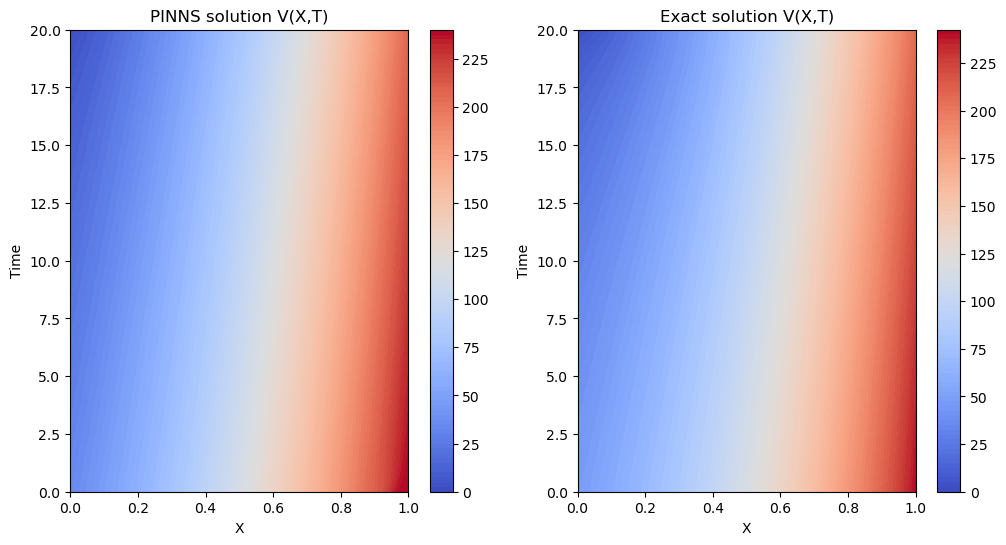

In [471]:
def BS_Call_exact(x, t, T = T, vol = vol0, r = r0/252, K = K):

    d1 = (x + (r+(vol**2)/2)*(T-t) )/(vol* np.sqrt(T-t))
    d2 = d1 - vol* np.sqrt(T-t)

    V = K * np.exp(x) * norm.cdf(d1) - K * np.exp(-r*(T-t)) * norm.cdf(d2)
    
    return V
    
x = np.linspace(x_min,x_max,100)
t = np.linspace(0,T,100)

T_n, X = np.meshgrid(t, x)
r_node = np.full((100*100 ), max(0, r))
vol_node = np.full((100*100 ), max(0, vol0) )
X_in = np.stack((X.ravel(), T_n.ravel(), vol_node, r_node), axis=-1)
V_pred = BS_pinn.predict(X_in).reshape(len(x), len(t))

fig, ax  = plt.subplots(1,2 , figsize = (12,6))

im = ax[0].contourf(X, T_n, V_pred, cmap="coolwarm", levels=100)
ax[0].set_ylabel('Time')
ax[0].set_xlabel('X')
ax[0].set_title('PINNS solution V(X,T)')  
fig.colorbar(im, ax = ax[0])

im = ax[1].contourf(X, T_n, BS_Call_exact(X,T_n), cmap="coolwarm", levels=100)
ax[1].set_ylabel('Time')
ax[1].set_xlabel('X')
ax[1].set_title('Exact solution V(X,T)')
fig.colorbar(im, ax = ax[1])

plt.show()

In [475]:
x = tf.constant(0.9)
t = tf.constant(1.)

X = np.array([[ x, t,  1.,  1. ]])
X_in = tf.cast(X,dtype = 'float64')
Greeks(BS_pinn, X_in)

{'Delta': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.9242214]])>,
 'Gamma': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.00268342]])>,
 'theta': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-1.17279208]])>,
 'Vega': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[78.16457167]])>,
 'rho': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-1112.19976211]])>}

In [514]:
BS_pinn.save_weights("BS_pinn.weights.h5")